In [1]:
import pandas as pd
train = pd.read_feather('Feathers/processed_train_data.feather')
train.head()

,text,label
0,reader mail sc ruling alimony supreme court ex...,0
1,niqaab elephant courtroom say uk judge person ...,0
2,grandparent honoured staff student global publ...,0
3,guardian quick crossword convinced know pay news,0
4,fisherman call strike country boat fisherman p...,1


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.75, min_df = 0.01)),
    ('rus', RandomUnderSampler(sampling_strategy = 0.5)),
    ('smt', SMOTE()),
    ('tmk', TomekLinks()),
    ('clf', DecisionTreeClassifier(random_state=28)),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams, bigrams or trigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_depth': (10, 15, 20, None),
    'clf__max_features': ('sqrt', 'log2', None)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search.fit(train.text, train.label)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.6min finished


Best score: 0.772
Best parameters set:
	clf__max_depth: 15
	clf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l1'
	tfidf__smooth_idf: False
	tfidf__use_idf: True


In [3]:
test = pd.read_feather('Feathers/processed_test_data.feather')
test.head()

,text,label
0,ranipet student top vellore district special c...,0
1,science camp schoolchildren science camp merit...,0
2,bahutule retires five day th birthday vidarbha...,0
3,heavy rain likely next three day woman reporte...,0
4,police complaint caste hindu dalit resident pa...,0


              precision    recall  f1-score   support

           0       0.99      0.94      0.97       456
           1       0.85      0.98      0.91       150

    accuracy                           0.95       606
   macro avg       0.92      0.96      0.94       606
weighted avg       0.96      0.95      0.95       606



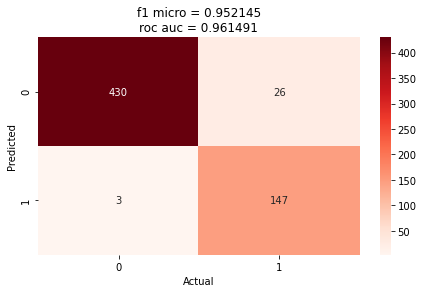

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_pred = grid_search.predict(train.text)
print(classification_report(train.label, y_pred))

conf_matrix = confusion_matrix(train.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('f1 micro = %f\nroc auc = %f' %(f1_score(train.label, y_pred, average='micro'), roc_auc_score(train.label, y_pred)))
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       153
           1       0.63      0.66      0.65        50

    accuracy                           0.82       203
   macro avg       0.76      0.77      0.76       203
weighted avg       0.83      0.82      0.82       203



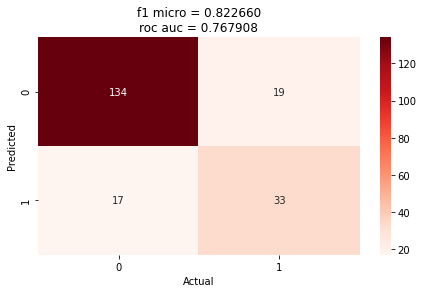

In [5]:
y_pred = grid_search.predict(test.text)
print(classification_report(test.label, y_pred))
conf_matrix = confusion_matrix(test.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('f1 micro = %f\nroc auc = %f' %(f1_score(test.label, y_pred, average='micro'), roc_auc_score(test.label, y_pred)))
plt.show()

In [6]:
d = {
    'Model': 'Decision Tree',
    'Training Set F1': f1_score(train.label, grid_search.predict(train.text), average='micro'),
    'Training Set ROC AUC': roc_auc_score(train.label, grid_search.predict(train.text)),
    'Test Set F1': f1_score(test.label, y_pred, average='micro'),
    'Test Set ROC AUC': roc_auc_score(test.label, y_pred)
}

df_models_dt = pd.DataFrame(d, index=[0])
df_models_dt

,Model,Training Set F1,Training Set ROC AUC,Test Set F1,Test Set ROC AUC
0,Decision Tree,0.952145,0.961491,0.82266,0.767908


In [7]:
df_models_dt.to_feather('Feathers/Models/dt.feather')